# Problem Set 2

## Question 4

Do Exercise 26.12 in Hansen (2022).

Take the ``cps09mar`` dataset and the subsample of individuals with ``education=20`` (professional
degree or doctorate), with ``experience`` between 0 and 40 years.

(a) Use Nadaraya-Watson to estimate the regression of log(``wage``) on ``experience``, separately for men
and women. Plot with 95% confidence intervals. Comment on how the estimated wage profiles
vary with experience. In particular, do you think the evidence suggests that expected wages fall for
experience levels above 20 for this education group?

In [1]:
#Setup for the implementation

#Kernel function
import numpy as np

def g_kernel(u):
    """
    The Gaussian kernel
    """
    K = np.exp(-u**2/2)/np.sqrt(2*np.pi)
    return K

#Nadaraya-Watson/Local linear estimator
def kernel_estimator(est_type, Y, X, h_n, x):
    
    n = len(Y)
    
    if est_type == "NW":
        Z = np.asmatrix(np.ones(n)).T
    elif est_type == "LL":
        Z_1 = np.asmatrix(np.ones(n))
        Z_2 = np.asmatrix([(x - Xi) for Xi in X])
        Z = np.vstack((Z_1,Z_2)).T
    else: 
        print("Error! Please choose either NW/LL.")
        
    K_values = [g_kernel((x - Xi)/h_n) for Xi in X]        
    K = np.eye(n) * K_values
    Y = np.asmatrix(Y).T
    
    est = (Z.T@K@Z).I @ (Z.T@K@Y)
    est_value = est[0].item()
    
    return est_value 

#Do cross validation to find the best bandwidth h based on user-defined grid (h_grid)
def cv_h(est_type, h_grid, Y, X):
    n = len(Y) 
    best_h = h_grid[0]
    best_mse = 999999999
    for h in h_grid:
        error_list = [Y[i] - kernel_estimator(est_type = est_type, 
                                              Y = np.delete(Y, i), #leave-one-out
                                              X = np.delete(X, i), 
                                              h_n = h, 
                                              x = X[i]) for i in range(0,n)]
        sq_error_list = [j**2 for j in error_list]
        mse = sum(sq_error_list)/n
        if mse<best_mse:
            best_mse = mse
            best_h = h
    return best_mse, best_h

#Setup of calculating the asymptotic variance of the estimator to construct confidence inter

#White type estimator of V_hat
def V_hat(est_type, Y, X, h_n, x):  
    
    n = len(Y)
    
    if est_type == "NW":
        Z = np.asmatrix(np.ones(n)).T
    elif est_type == "LL":
        Z_1 = np.asmatrix(np.ones(n))
        Z_2 = np.asmatrix([(x - Xi) for Xi in X])
        Z = np.vstack((Z_1,Z_2)).T
    else: 
        print("Error! Please choose either NW/LL.")

    loo_error_list = [Y[i] - kernel_estimator(est_type = est_type, 
                        Y = np.delete(Y, i), #leave-one-out
                        X = np.delete(X, i), 
                        h_n = h_n, 
                        x = X[i]) for i in range(0,n)]
    
    loo_error_list_sq = [j**2 for j in loo_error_list]
    
    K_values = [g_kernel((x - Xi)/h_n) for Xi in X]        
    K = np.eye(n) * K_values
    Y = np.asmatrix(Y).T
    
    mid_var_est = sum([(K_values[m]**2)*loo_error_list_sq[m]*(Z[m].T@Z[m]) for m in range(0,n)])
    
    est = (Z.T@K@Z).I @ mid_var_est @ (Z.T@K@Z).I
    est_value = est[0,0].item()
    
    return est_value
    

In [2]:
def kernel_plot(female, est_type):
    
    import pandas as pd
    import numpy as np

    #Import the data
    raw_data = pd.read_stata("https://www.ssc.wisc.edu/~bhansen/econometrics/cps09mar.dta")

    #New variable ``experience`` = ``age`` - ``education`` - 6
    raw_data["experience"] = raw_data["age"] - raw_data["education"] - 6

    #Subsetting the data
    data = raw_data[(raw_data.education == 20) & (raw_data.experience>=0) & (raw_data.experience<=40)].copy()

    #Generate ``log_wage``
    data["log_wage"] = np.log(data["earnings"]/(data["hours"]*data["week"])).values

    #Get only relevant variables ``log(wage)`` and ``experience``
    data = data[["female","log_wage","experience"]]
    data_men = data[data.female == 0].copy()
    data_female = data[data.female == 1].copy()

    if female == True:
        y = data_female["log_wage"].values
        z = data_female["experience"].values 
    else:
        y = data_men["log_wage"].values
        z = data_men["experience"].values
        
    n = len(y)
    
    #Do cross-validation to find the optimal h
    h_opt = cv_h(est_type = est_type, h_grid = np.linspace(1, 10, 20), Y = y, X = z)[1]
        
    #First get the kernel estimator
    exp_grid = np.linspace(0, 40, 20)
    theta_value_list = [kernel_estimator(est_type = est_type, Y = y, X = z, h_n = h_opt, x = p) for p in exp_grid]
    
    #Estimate the V_hat
    V_hat_value_list = [V_hat(est_type = est_type, Y = y, X = z, h_n = h_opt, x = p) for p in exp_grid]
    
    #lowerbond of ci
    ci_lower = [j[0] -  1.96*np.sqrt(j[1]) for j in zip(theta_value_list, V_hat_value_list)]
    
    #upperbond of ci
    ci_upper = [j[0] +  1.96*np.sqrt(j[1]) for j in zip(theta_value_list, V_hat_value_list)]
    
    #Ready to plot
    import matplotlib.pyplot as plt
    plt.plot(exp_grid, theta_value_list)
    plt.plot(exp_grid, ci_lower, linestyle = "dashed", color='grey')
    plt.plot(exp_grid, ci_upper, linestyle = "dashed", color='grey')
    if female == False:
        gender = " Men"
    else:
        gender = " Women"
    plt.title(est_type + " estimator for condition expectation of log(wage) for"+ gender + "(h = " + str(np.round(h_opt,2)) +")")
    plt.xlabel("Experience")
    plt.show()

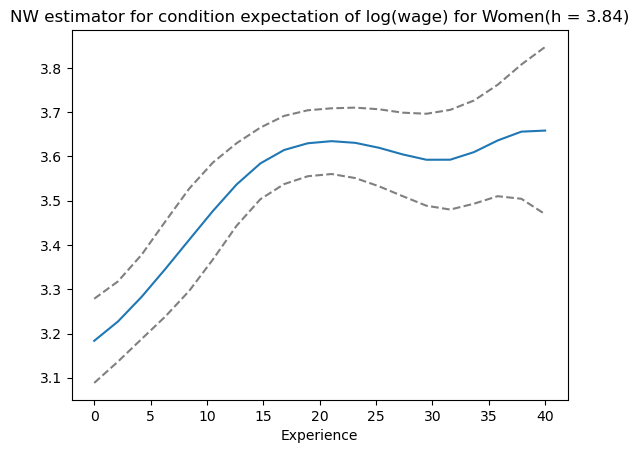

In [3]:
#For female
kernel_plot(female = True, est_type = "NW")

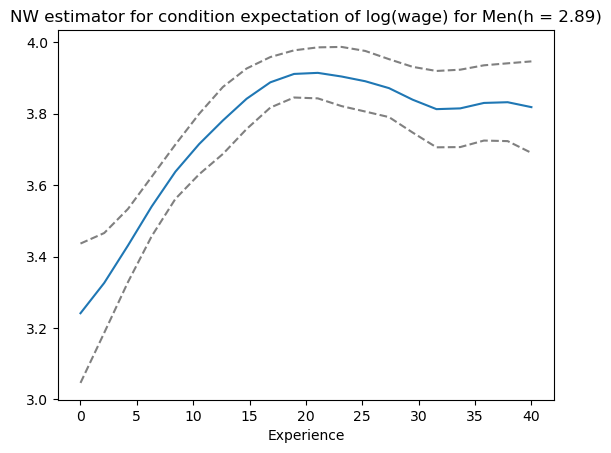

In [4]:
#For male
kernel_plot(female = False, est_type = "NW")

(b) Repeat using the Local Linear estimator. How do the estimates and confidence intervals change?

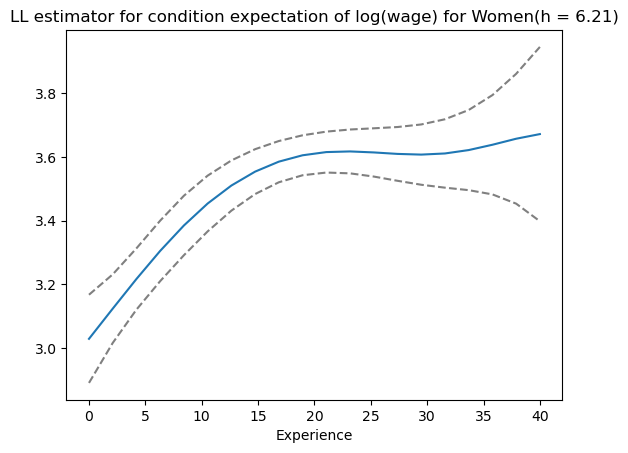

In [5]:
#For female
kernel_plot(female = True, est_type = "LL")

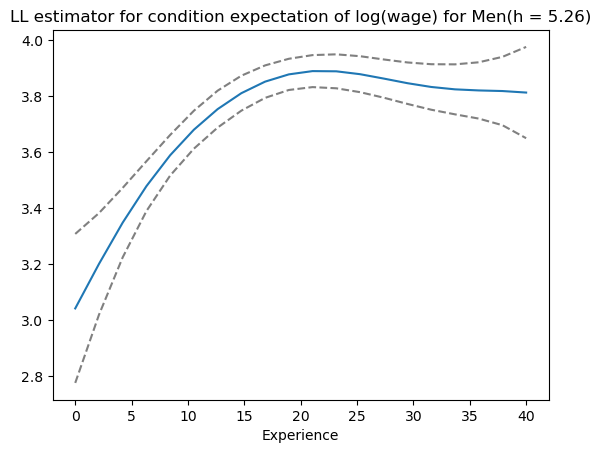

In [6]:
#For male
kernel_plot(female = False, est_type = "LL")